# Impor Beberapa Package

In [1]:
from netCDF4 import Dataset
import wrf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# Direktori WRF

In [2]:
wrf_path = '/home/absen/WRF-Model/WRF/test/em_real'

# Buka salah satu file `wrfout*`

In [3]:
wrf_d03 = Dataset(f"{wrf_path}/wrfout_d03_2022-01-01_00:00:00")

# Mengetahui Variabel di dalam file `wrfout_d03`

In [ ]:
wrf_d03.variables.keys()

# Mengambil Variabel `T2` untuk semua waktu simulasi

In [4]:
wrf_t2 = wrf.getvar(wrf_d03, "T2", timeidx=wrf.ALL_TIMES)

# Mengambil Variabel Waktu

In [5]:
wrf_time = wrf.getvar(wrf_d03, 'times', timeidx=wrf.ALL_TIMES)

# Mendapatkan nilai koordinat (Latitude dan Longitude)

In [6]:
# Get the latitude and longitude points
lats, lons = wrf.latlon_coords(wrf_t2)

# Membuat Plot Spasial

In [7]:
# Choose time
time     = "2022-01-02 13:00:00"
time     = np.array([time], dtype='datetime64[ns]')
time_idx = np.where(wrf_time.values == time)[0]
time_idx = int(time_idx)

In [ ]:
# Get the cartopy mapping object
cart_proj = wrf.get_cartopy(wrf_t2, timeidx=time_idx)

# Smooth the air temperature
smooth_t2 = wrf.smooth2d(wrf_t2, 3)

# Create a figure
fig = plt.figure(figsize=(12,10))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add features to axes object 
ax.coastlines(linewidth=0.8, resolution='10m')

# Activate gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add features to the map like contour lines
# Set contour levels 
lvl = np.arange(290, 304, 2) # Non-inclusive of end value (1030)

# Add contour lines
# plt.contour(lons,
#             lats,
#             wrf_t2, 
#             levels=lvl,
#             colors='k',
#             transform=crs.PlateCarree())

# Add filled contour lines
plt.contourf(lons, lats, smooth_t2[time_idx, :, :],
            levels=lvl,
            transform=crs.PlateCarree(),
            cmap='viridis')

# Add colorbar
plt.colorbar(ax=ax, shrink=0.7)

# Manually set extent of map projection
# ax.set_extent([])

plt.show()

# Time Series

In [42]:
# Define the lat and lon of the point to extract
lats_sel, lons_sel = -7.271372797667375, 112.73417496409039

# Extract the air temperature data at that points
lats_lons_idx = wrf.ll_to_xy(wrf_d03, lats_sel, lons_sel)
wrf_t2_sel = wrf_t2[:, lats_lons_idx[1], lats_lons_idx[0]]

<xarray.DataArray 'T2' (Time: 67)>
array([299.69034, 301.19342, 302.30685, 303.5377 , 304.3356 , 303.75574,
       303.43555, 303.3089 , 303.2937 , 302.67404, 301.98993, 301.78656,
       298.1735 , 296.78204, 296.3072 , 296.31088, 298.31134, 298.38098,
       297.63406, 297.88785, 297.7154 , 298.2292 , 298.43936, 298.76404,
       299.56323, 300.60416, 301.61914, 302.7237 , 304.3566 , 305.363  ,
       305.0653 , 304.7053 , 303.76883, 299.78656, 297.56882, 297.20215,
       297.4546 , 297.8117 , 297.89493, 298.4532 , 298.58057, 298.9187 ,
       298.39676, 298.85822, 299.1962 , 299.33368, 299.5007 , 299.17935,
       300.05194, 300.8717 , 302.27533, 303.644  , 304.51135, 305.06616,
       305.73505, 305.59158, 305.5028 , 303.27924, 303.20096, 302.16855,
       301.18274, 301.08987, 301.15854, 300.8965 , 300.7514 , 300.6325 ,
       300.8598 ], dtype=float32)
Coordinates:
    XLONG         float32 112.7
    XLAT          float32 -7.266
    XTIME         (Time) float32 0.0 60.0 120.0 ... 3.84e+03 3.9e+03 3.96e+03
  * Time          (Time) datetime64[ns] 2022-01-01 ... 2022-01-03T18:00:00
    latlon_coord  object CoordPair(lat=-7.271372797667375, lon=112.7341749640...
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=1.0000000200408773e+20, moad_cen_lat=-7....

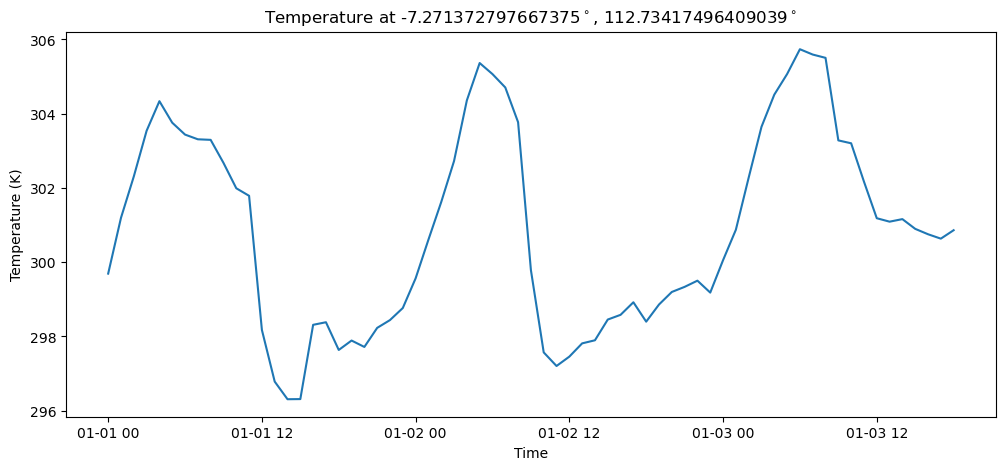

In [52]:
# Plot the data
fig = plt.figure(figsize=(12,5))
ax  = plt.axes()

ax.plot(wrf_time, wrf_t2_sel.values)

ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
ax.set_title(f"Temperature at {lats_sel}$^\circ$, {lons_sel}$^\circ$")

plt.show()

# Menghitung Curah Hujan Setiap Jam

In [111]:
# Get RAINC & RAINNC 
rainc  = wrf.getvar(wrf_d03, "RAINC", timeidx=wrf.ALL_TIMES)
rainnc = wrf.getvar(wrf_d03, "RAINNC", timeidx=wrf.ALL_TIMES)

# Get attribute
rain_attr = rainc.attrs

In [198]:
# Sum RAINC & RAINNC
rain = rainc + rainnc
rain_d = rain.copy()
# Substract for each time step with the previous time step
# 1, 2, 3, 4, 5, ..., 66
# 0, 1, 2, 3, 4, ..., 65
# _____________ -

for i in range(1, 67):
    rain_d[i, :, :] = rain[i, :, :] - rain[i-1, :, :]

# rain_d = rain[1:67, :, :] - rain[0:66, :, :]

# Assign attribute
rain_d.attrs = rain_attr

# Assign description attribute
rain_d.attrs["description"] = "Total precipitation"

In [199]:
rain_d.to_numpy().max()

105.93535

In [ ]:
# Get the cartopy mapping object
cart_proj = wrf.get_cartopy(rain_d, timeidx=20)

# Smooth the air temperature
# smooth_rain = wrf.smooth2d(rain, 2)

# Create a figure
fig = plt.figure(figsize=(12,10))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add features to axes object 
ax.coastlines(linewidth=0.8, resolution='10m')

# Activate gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add features to the map like contour lines
# Set contour levels 
lvl = np.arange(1, 150, 5) # Non-inclusive of end value (1030)

# Add contour lines
# plt.contour(lons,
#             lats,
#             wrf_t2, 
#             levels=lvl,
#             colors='k',
#             transform=crs.PlateCarree())

# Add filled contour lines
plt.contourf(lons, lats, rain_d[60, :, :],
            levels=lvl,
            transform=crs.PlateCarree(),
            cmap='viridis')

# Add colorbar
plt.colorbar(ax=ax, shrink=0.7)

# Manually set extent of map projection
# ax.set_extent([])

plt.show()